#Hand Gesture Recognition Based On Deep Learning Approach

#Introduction
Hand gesture recognition is a significant area of research in computer vision and human-computer interaction. This project aims to develop a system that can accurately recognize hand gestures using machine learning techniques. The system utilizes a dataset of hand gesture images, processes them, and applies a classification model to identify the gestures. The primary goal is to achieve high accuracy in recognizing various hand gestures, which can have applications in fields such as virtual reality, sign language interpretation, and robotics.

#Motivation
The motivation behind this project stems from the growing demand for intuitive and natural ways to interact with technology. Hand gestures are a fundamental form of human communication, making them a promising modality for human-computer interaction. By leveraging deep learning, this project aims to create a robust hand gesture recognition system that bridges the gap between human intent and machine understanding.

**Healthcare:** Assisting individuals with disabilities, such as those with motor impairments or autism, by providing alternative means of communication and interaction.

**Assistive Technology:** Empowering individuals with disabilities by enabling interaction through gestures, such as interpreting sign language.

**Robotics and Automation:** Enabling robots to understand and respond to human commands in environments like healthcare, manufacturing, and service industries.

**Smart Environments**: Facilitating seamless interaction with IoT devices using natural gestures, creating smarter homes and workplaces.

#Objectives
Develop a Real-time System: Create a system to identify hand gestures instantly.

**Enhance Image Quality:** Apply preprocessing techniques for better input images.

**Extract Features:** Use MobileNetV2 for effective feature extraction from images.

**Train Classifier:** Train an SVM model on the extracted features.

**Optimize Accuracy:** Improve gesture recognition accuracy through data augmentation.

**Real-time Capability:** Implement real-time gesture recognition for practical use.

**User Interface:** Design a simple and intuitive interface for user interaction.

#Source Code:

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
from torchvision.utils import save_image
!pip install torchsummary
from torchsummary import summary

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/HandGesture/Handgesture/images'
AUGMENTED_PATH = '/content/drive/MyDrive/Colab Notebooks/HandGesture/Handgesture/augmented_images'
PROCESSED_PATH = '/content/drive/MyDrive/Colab Notebooks/HandGesture/Handgesture/processed_images'

In [ ]:
# Function to save images
def save_images(data, path, transform=None):
    for i, (img, label) in tqdm(enumerate(data), total=len(data)):
        # Apply transformations if any
        if transform:
            img = transform(img)

        # Create label-specific directory
        label_dir = os.path.join(path, dataset.classes[label])
        os.makedirs(label_dir, exist_ok=True)

        # Save image with a unique name
        save_image(img, os.path.join(label_dir, f'image_{i}.png'))


In [ ]:
# Augmented images with additional transformations
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Processed images
processed_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load dataset using ImageFolder without initial transform
dataset = ImageFolder(root=DATASET_PATH)

# Save augmented images
save_images(dataset, AUGMENTED_PATH, transform=augmentation_transform)

# Save processed images
save_images(dataset, PROCESSED_PATH, transform=processed_transform)

  0%|          | 0/2197 [00:00<?, ?it/s]

  0%|          | 0/2197 [00:00<?, ?it/s]

# Feature Extraction and Label Preparation

In [ ]:
# Split dataset into training, validation, and test sets
dataset = ImageFolder(root=DATASET_PATH, transform=processed_transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

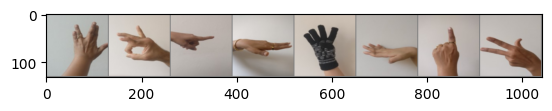

In [ ]:
# Display sample images
def imshow(img):
    img = img / 2 + 0.5  # Denormalize the image to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(make_grid(images[:8]))

# Model Training

In [ ]:
# Pretrained model (ResNet18)
class PatternClassificationModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(PatternClassificationModel, self).__init__()
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC layer
        self.flatten = nn.Flatten()  # Flatten connection
        self.fc1 = nn.Linear(base_model.fc.in_features, 512)  # Additional dense layer
        self.fc2 = nn.Linear(512, 256)  # Additional dense layer
        self.fc3 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.feature_extractor(x)  # Feature extraction
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  # First FC layer
        x = F.relu(self.fc2(x))  # Second FC layer
        x = self.fc3(x)  # Output layer
        return x


In [ ]:
# Initialize the base model and main model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_resnet18 = models.resnet18(pretrained=True)
num_classes = len(dataset.classes)
main_model = PatternClassificationModel(base_resnet18, num_classes).to(device)

In [ ]:
summary(main_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001)

In [ ]:
# Training the updated model
num_epochs = 18
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    main_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = main_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)

    # Validation phase
    main_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 1, Loss: 1.6880, Accuracy: 36.89%, Validation Loss: 1.9619, Validation Accuracy: 41.64%


Epoch 2/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 2, Loss: 1.3037, Accuracy: 51.01%, Validation Loss: 2.0625, Validation Accuracy: 28.57%


Epoch 3/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 3, Loss: 1.1421, Accuracy: 59.99%, Validation Loss: 1.8631, Validation Accuracy: 48.94%


Epoch 4/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 4, Loss: 0.9202, Accuracy: 67.01%, Validation Loss: 1.4239, Validation Accuracy: 56.84%


Epoch 5/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 5, Loss: 0.8415, Accuracy: 70.46%, Validation Loss: 1.3464, Validation Accuracy: 57.14%


Epoch 6/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 6, Loss: 0.7975, Accuracy: 74.95%, Validation Loss: 1.0822, Validation Accuracy: 65.96%


Epoch 7/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 7, Loss: 0.5719, Accuracy: 80.55%, Validation Loss: 2.2223, Validation Accuracy: 60.49%


Epoch 8/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 8, Loss: 0.5048, Accuracy: 83.73%, Validation Loss: 1.1339, Validation Accuracy: 66.26%


Epoch 9/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 9, Loss: 0.4484, Accuracy: 85.56%, Validation Loss: 1.3246, Validation Accuracy: 62.31%


Epoch 10/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 10, Loss: 0.4562, Accuracy: 88.35%, Validation Loss: 1.3323, Validation Accuracy: 63.22%


Epoch 11/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 11, Loss: 0.2953, Accuracy: 91.48%, Validation Loss: 1.9168, Validation Accuracy: 65.05%


Epoch 12/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 12, Loss: 0.3753, Accuracy: 88.68%, Validation Loss: 1.5903, Validation Accuracy: 63.22%


Epoch 13/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 13, Loss: 0.3401, Accuracy: 93.17%, Validation Loss: 1.0939, Validation Accuracy: 75.99%


Epoch 14/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 14, Loss: 0.1955, Accuracy: 95.06%, Validation Loss: 1.5107, Validation Accuracy: 73.56%


Epoch 15/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 15, Loss: 0.2129, Accuracy: 94.14%, Validation Loss: 1.2820, Validation Accuracy: 70.82%


Epoch 16/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 16, Loss: 0.2914, Accuracy: 93.10%, Validation Loss: 1.1825, Validation Accuracy: 72.64%


Epoch 17/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 17, Loss: 0.2281, Accuracy: 95.90%, Validation Loss: 1.2449, Validation Accuracy: 75.38%


Epoch 18/18:   0%|          | 0/49 [00:00<?, ?batch/s]

Epoch 18, Loss: 0.1438, Accuracy: 96.81%, Validation Loss: 1.6964, Validation Accuracy: 68.09%


In [ ]:
# Save the model
torch.save(main_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/HandGesture/gesture_recognition_model_v2.pth')
print("Model training completed and saved!")

Model training completed and saved!


#Validation

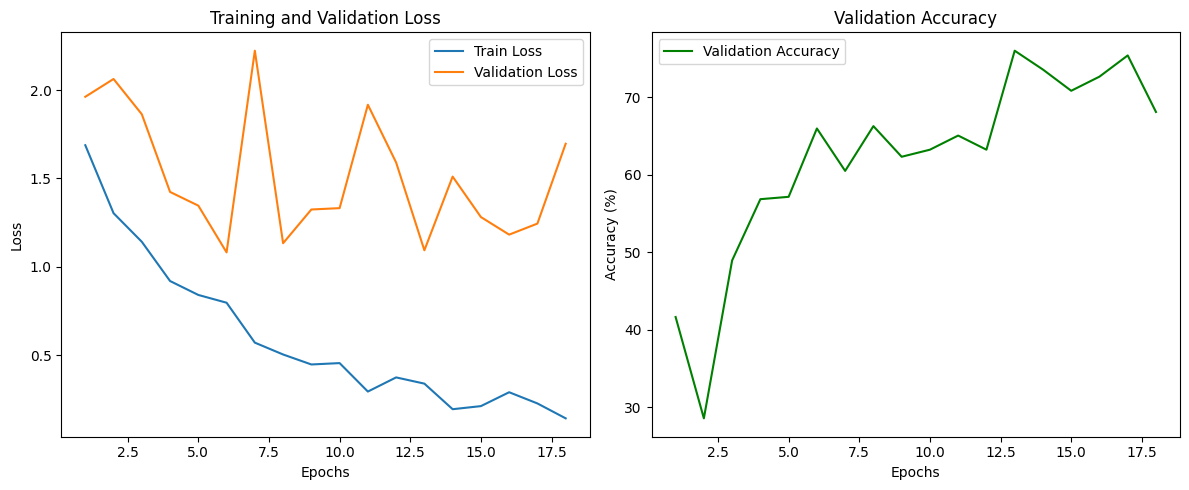

In [ ]:
# Performance Metrics and Validation Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model performance

In [ ]:
def evaluate_model(model, data_loader, dataset_name='Test'):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f'Evaluating on {dataset_name} Set'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # Classification report
    print(f'Classification Report for {dataset_name} Set:')
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Accuracy
    accuracy = 100 * np.sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
    print(f'{dataset_name} Accuracy: {accuracy:.2f}%')

Evaluating on Test Set:   0%|          | 0/11 [00:00<?, ?it/s]

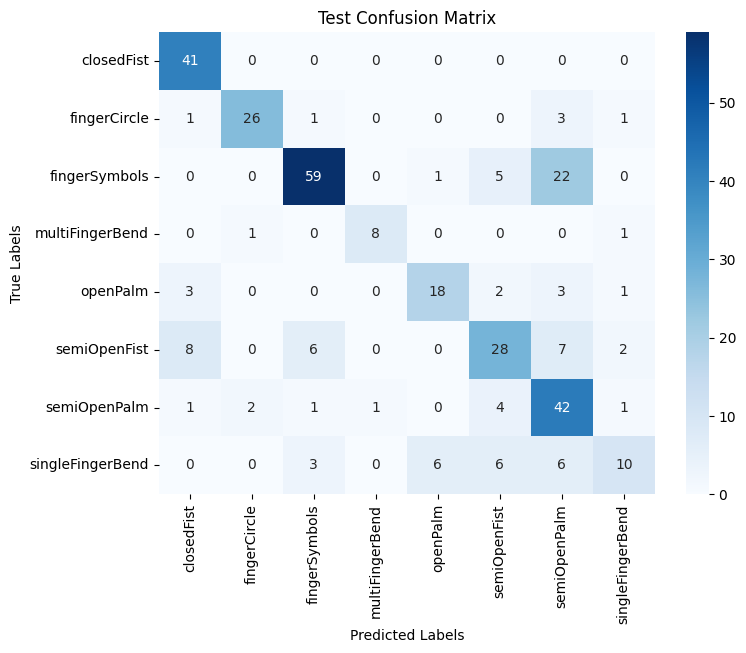

Classification Report for Test Set:
                  precision    recall  f1-score   support

      closedFist       0.76      1.00      0.86        41
    fingerCircle       0.90      0.81      0.85        32
   fingerSymbols       0.84      0.68      0.75        87
 multiFingerBend       0.89      0.80      0.84        10
        openPalm       0.72      0.67      0.69        27
    semiOpenFist       0.62      0.55      0.58        51
    semiOpenPalm       0.51      0.81      0.62        52
singleFingerBend       0.62      0.32      0.43        31

        accuracy                           0.70       331
       macro avg       0.73      0.70      0.70       331
    weighted avg       0.72      0.70      0.70       331

Test Accuracy: 70.09%


In [ ]:
# Evaluate on test set
evaluate_model(main_model, test_loader, dataset_name='Test')

#Conclusion:
The implemented hand gesture recognition system demonstrates moderate performance, achieving an accuracy of 70% on the test set. The confusion matrix and classification report indicate that certain gesture categories, such as closed fists and finger circles, are recognized with high precision and recall, while others, like semi-open fists and single finger bends, exhibit lower performance. This suggests the need for further refinement in data representation and model architecture

Potential improvements include:

Expanding the dataset to cover more diverse examples and variations of each gesture class.

Fine-tuning the ResNet-18 model with advanced techniques like learning rate scheduling and regularization.

Exploring alternative architectures or ensemble methods for better generalization.